In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import math

df = pd.read_csv('../data/raw/Customer_Churn_Dataset.csv')

**기본 정보**
- raw: 7043
- columns: 23
- category_col: customerID, gender, Partner, Dependents, PhoneService, MultipleLines, InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies, Contract, PaperlessBilling, PaymentMethod, TotalCharges, Churn
- numeric_col: SeniorCitizen(int), tenure(int), MonthlyCharges(float), numAdminTickets(int), numTechTickets(int)

In [6]:
print(df.shape) # (7043, 23)

(7043, 23)


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [11]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges,numAdminTickets,numTechTickets
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692,0.515689,0.419566
std,0.368612,24.559481,30.090047,1.275299,1.250117
min,0.000000,0.000000,18.250000,0.000000,0.000000
25%,0.000000,9.000000,35.500000,0.000000,0.000000
50%,0.000000,29.000000,70.350000,0.000000,0.000000
75%,0.000000,55.000000,89.850000,0.000000,0.000000
max,1.000000,72.000000,118.750000,5.000000,9.000000


**결측치 확인**
- 표면적으로 보이는 결측치는 없음

In [12]:
df.isna().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
numAdminTickets     0
numTechTickets      0
Churn               0
dtype: int64

In [ ]:
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
numAdminTickets     0
numTechTickets      0
Churn               0
dtype: int64


**시각화 확인**

In [15]:
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 5)

**기본 분포 확인(수치형)**

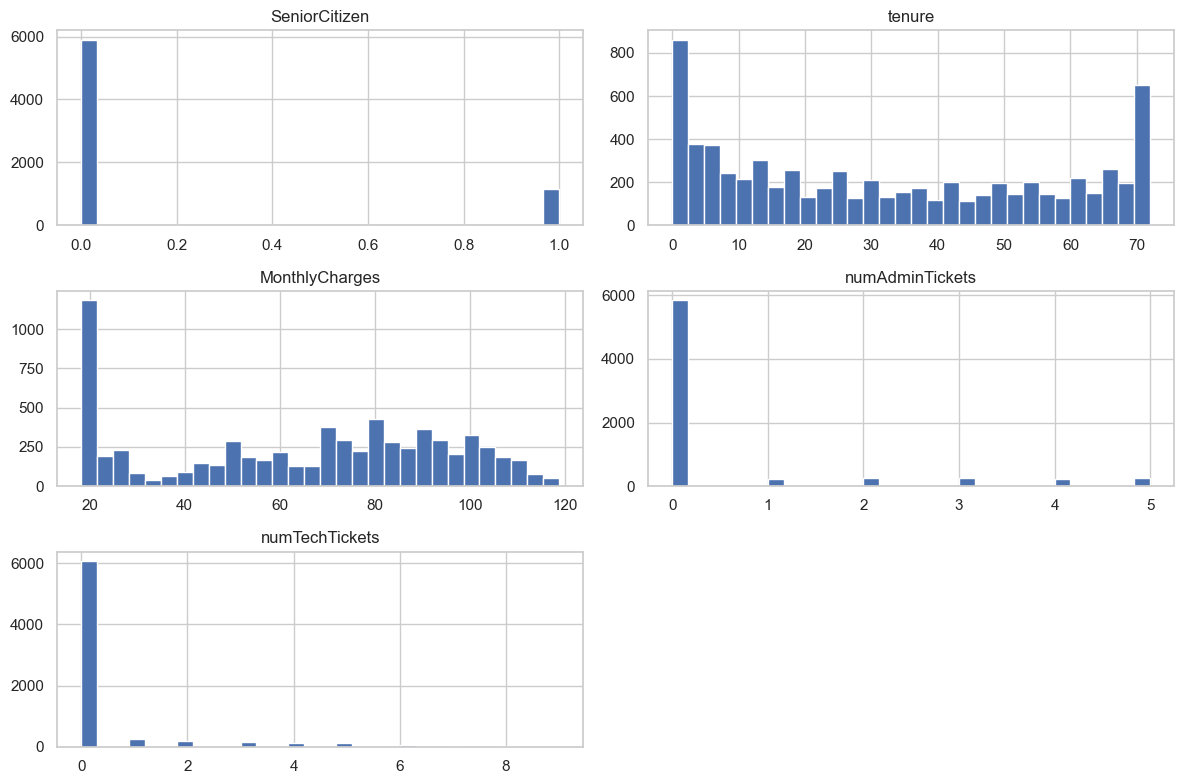

In [16]:
numeric_cols = df.select_dtypes(include=['int64','float64']).columns
df[numeric_cols].hist(bins=30, figsize=(12, 8))
plt.tight_layout()
plt.show()

**기본 분포 확인(범주형)**
- TotalCharges 타입 변경 필요해보임. object -> float.
- 결측치가 빈칸으로 존재해서 기존 float type이 object로 변환된 것으로 추정

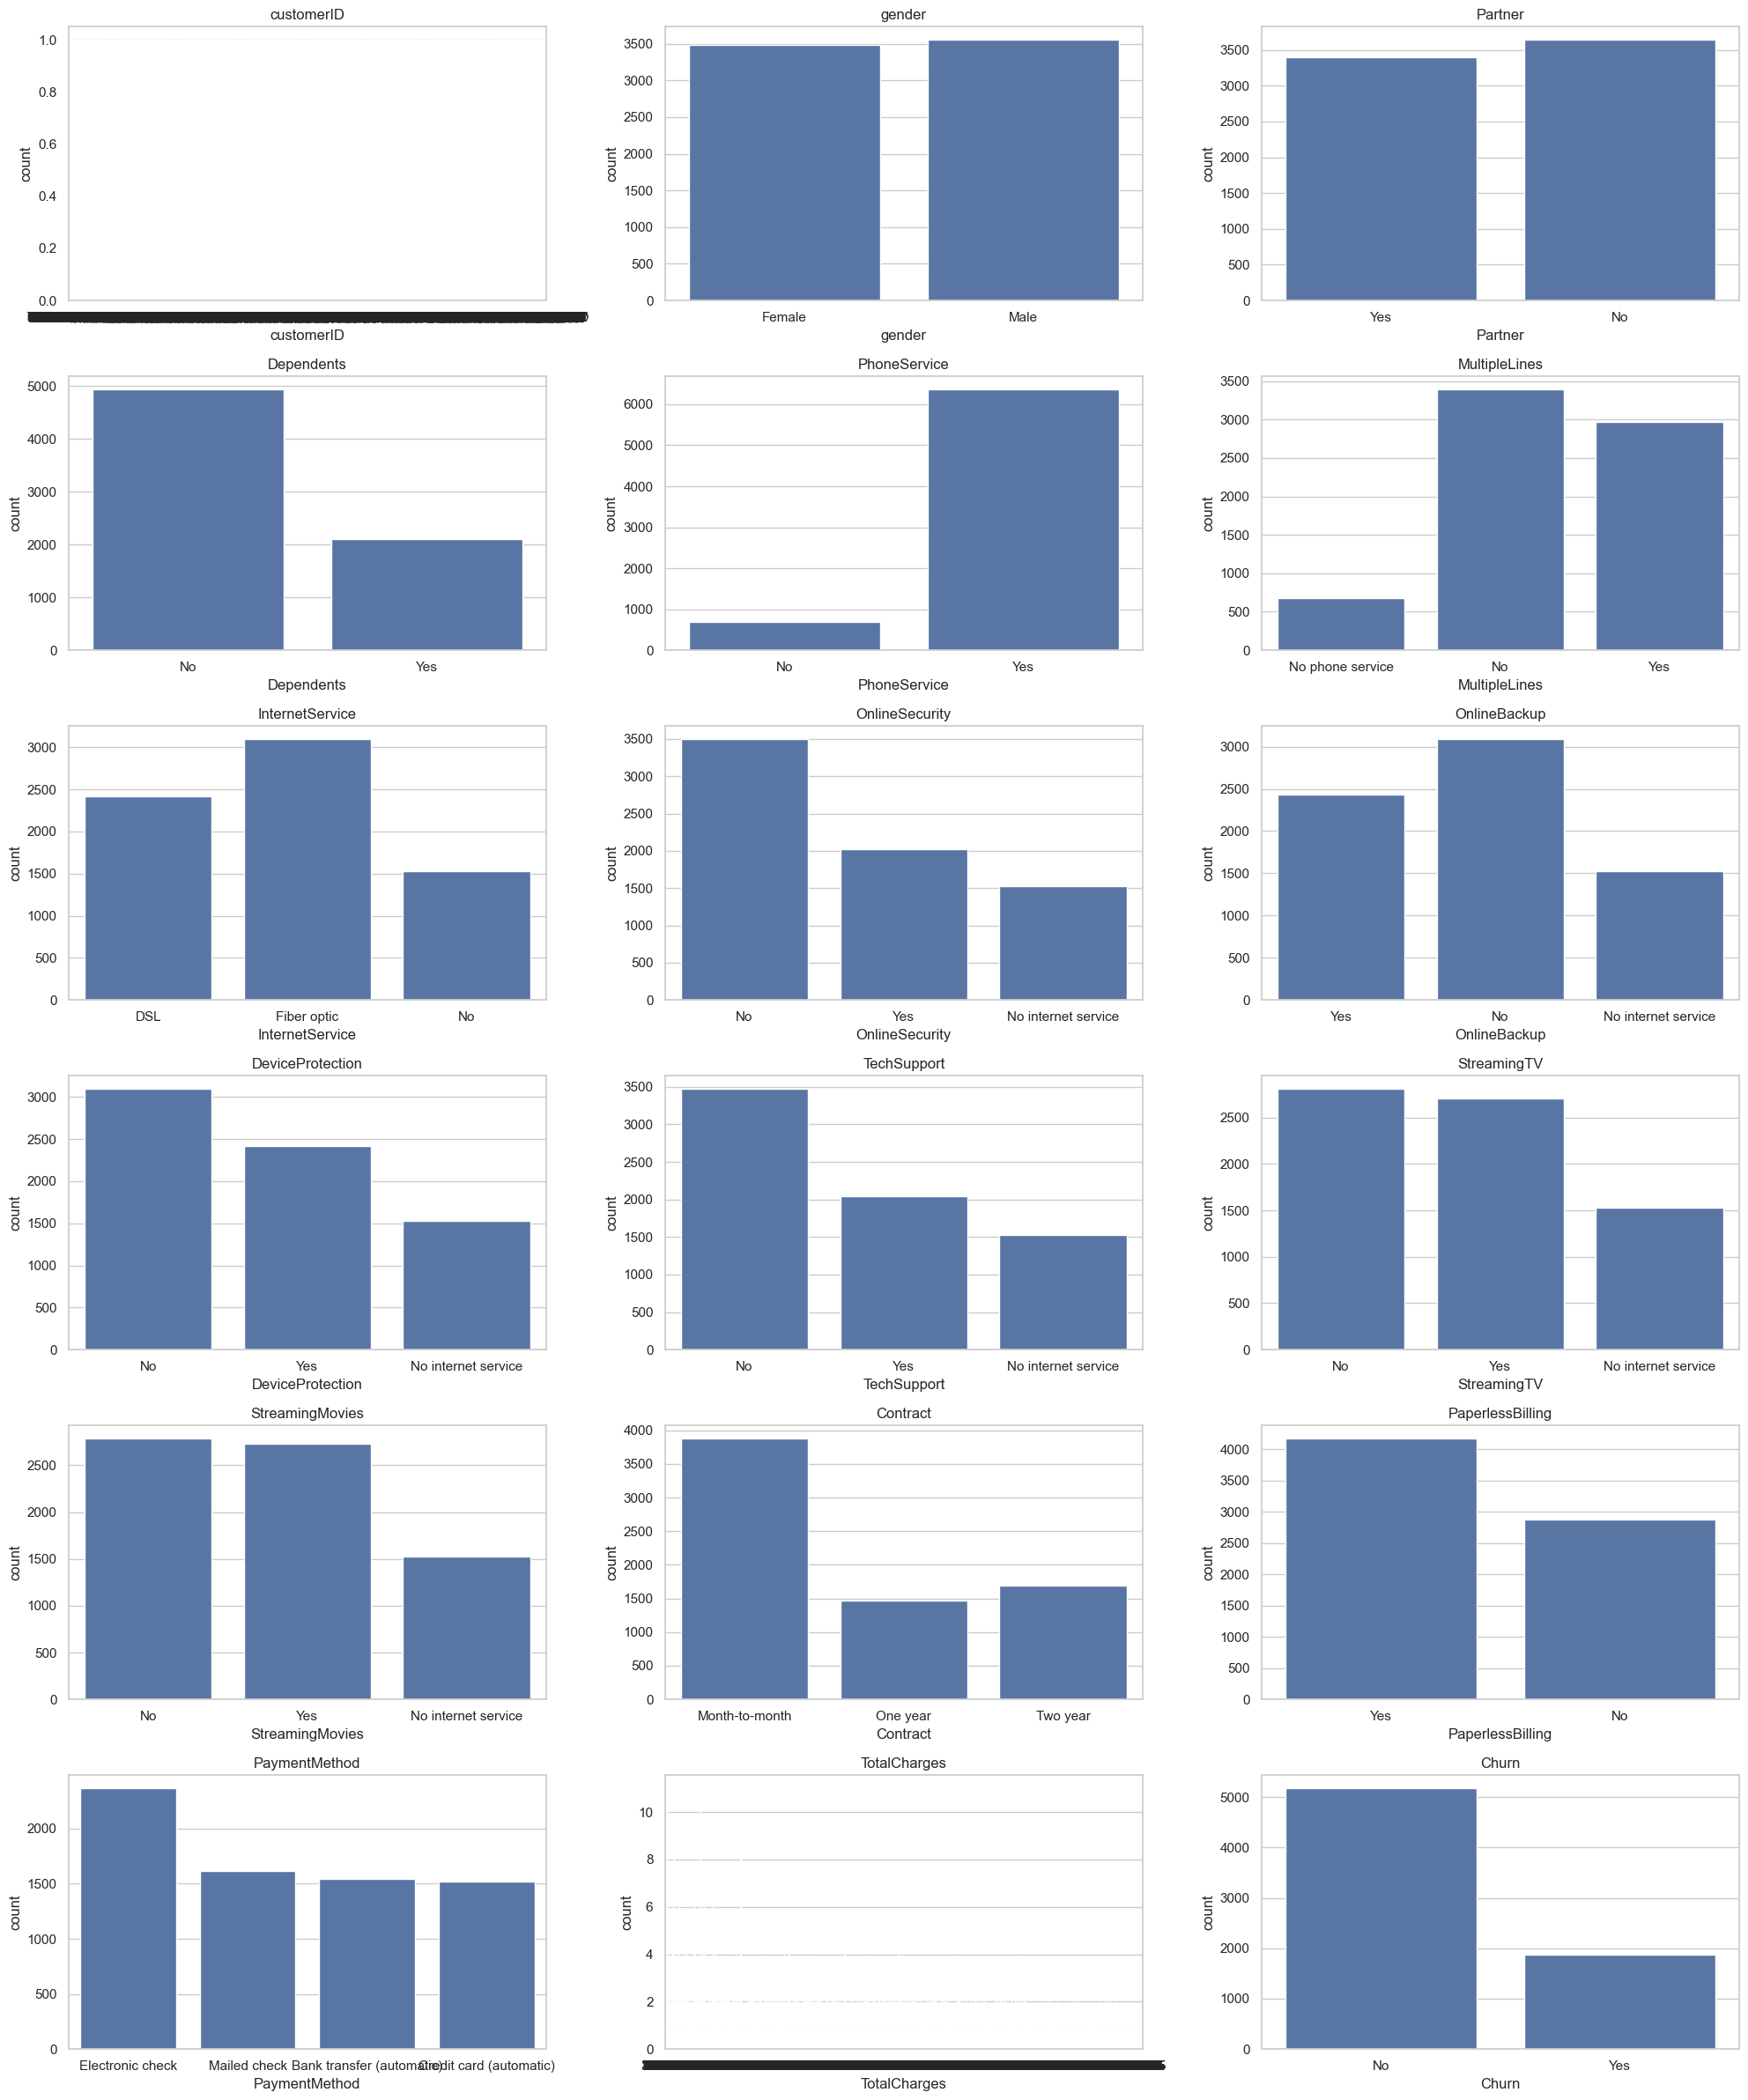

In [22]:
categorical_cols = df.select_dtypes(include=['object']).columns

n_cols = 3
n_rows = (len(categorical_cols) + n_cols -1) // n_cols

plt.figure(figsize=(20, n_rows * 4))

for i, col in enumerate(categorical_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.countplot(data=df, x=col)
    plt.title(col)

plt.tight_layout()
plt.show()

**Target 분포(Churn)**
- 비율이 73:27정도로 불균형 데이터.
- 기계학습 과정에서의 성능 개선을 위해 전처리가 필요

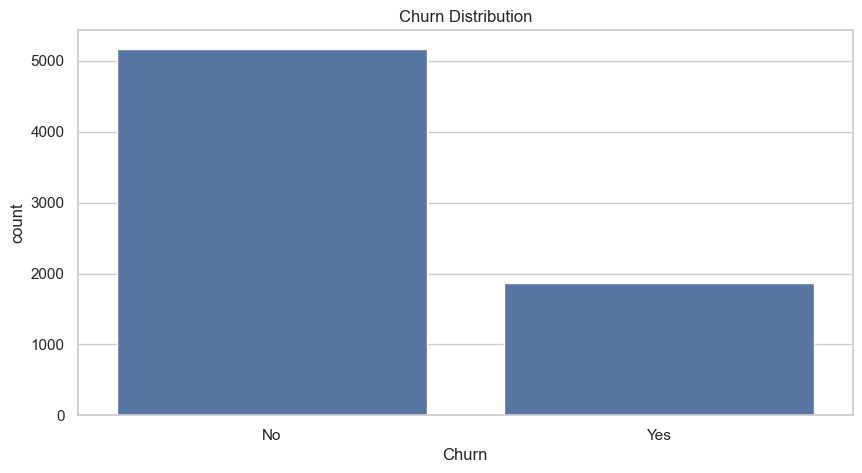

Churn
No     73.463013
Yes    26.536987
Name: proportion, dtype: float64

In [23]:
sns.countplot(data=df, x="Churn")  # Churn 컬럼명 확인
plt.title("Churn Distribution")
plt.show()

df["Churn"].value_counts(normalize=True) * 100

**상관관계 히트맵 (수치형 + Churn binary)**
- 서로 독립적인 수치형 변수들
- 수치형 feature들 간의 상관관계가 약하기 때문에, 기본적인 tree, linear 모델 모두 안정적 학습 가능
- 조합하여서 새 columns 만들기에는 상관관계가 약하다.
- tenure(이용기간)와 Churn(이탈)의 의미있는 상관계수가 존재. 이용기간이 높을 수록 이탈을 하지 않는다는 내용.
- numTechTickets(기술문제)와 Churn(이탈)의 의미있는 상관관계가 존재. 품질 문제가 있을 수록, 이탈을 한다.
- MonthlyCharges와 Churn의 약한 상관관계 존재(금액이 비싸면 이탈 증가한다.)
- SeniorCitizen과 Churn의 매우 약한 상관관계 존재(고령이면 이탈한다.)


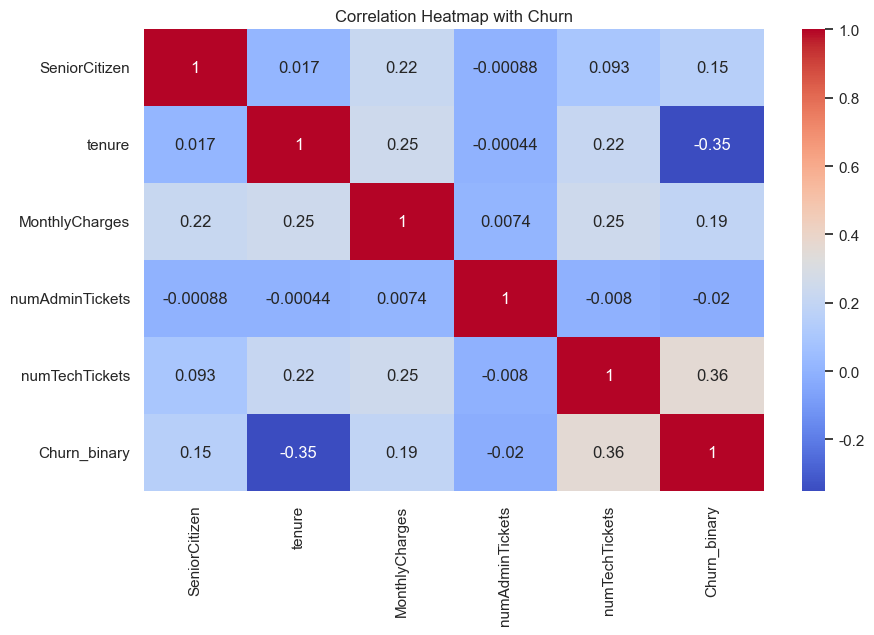

In [28]:
df_copy = df.copy()

df_copy['Churn_binary'] = df_copy['Churn'].map({'Yes': 1, 'No': 0})

numeric_cols = df_copy.select_dtypes(include=['int64', 'float64']).columns.tolist()

corr = df_copy[numeric_cols].corr()

plt.figure(figsize=(10,6))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap with Churn")
plt.show()

**Features vs Churn 관계(수치형)**
- vs SeniorCitizen: 거의 미미한 영향력. 통계적으로는 작은 영향이 있지만 시각적으로는 거의 드러나지 않음. >> 모델에서 주요 feature는 아니다.
- vs tenure: 강한 영향력. 핵심 feature
- vs MothlyCharges: 중간값이 전체적으로 Yes쪽이 높다. 핵심 feature
- vs numAdminTickets: 영향이 거의 없다. Feature Selection 단계에서 제거 후보
- vs numTechTickets: 약한 양의 상관관계. 조합형 feature 고려해볼 대상

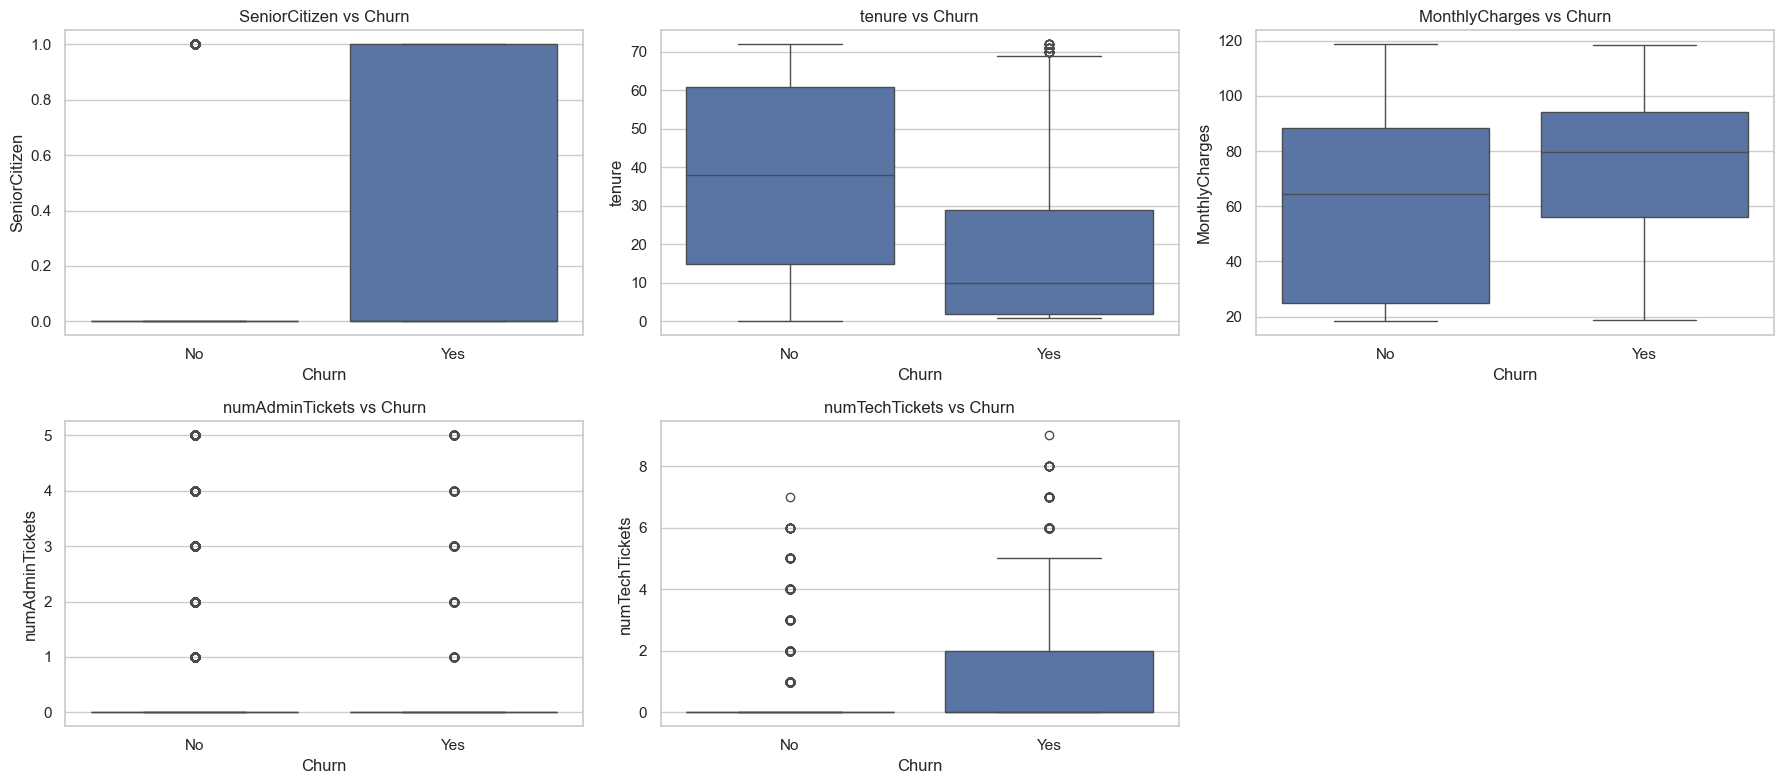

In [ ]:
numeric_cols = df.select_dtypes(include=['int64','float64']).columns

# Churn이 문자열이면 binary 변환 없이도 boxplot 가능함
n_cols = 3  # 한 줄에 3개씩
n_rows = math.ceil(len(numeric_cols) / n_cols)

plt.figure(figsize=(18, n_rows * 4))

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.boxplot(data=df, x="Churn", y=col)
    plt.title(f"{col} vs Churn")
    plt.tight_layout()

plt.show()

**Features vs Churn 관계(범주형)**
- vs CumstomerID: 식별번호.
- vs gender: 남녀 비율 동일, Churn과 무관
- vs Partner: 배우자 유무. 개별적 사용 의미x, 조합 시 의미 있음.
- vs Dependents: 부양가족 여부, Dependents=Yes인 고객이 이탈 매우 낮음 | Dependents=No가 압도적으로 Churn 높음. 중요 feature. 
- vs PhoneService: 의미 없음
- vs MultipleLines: 여러 회선 사용. 미약한 영향
- vs InternetService: Fiber optic 사용 고객이 Churn 비율 매우 높음, DSL 고객은 더 안정적. 매우 중요한 feature
- vs OnlineSecurity: 보안서비스, 강한 음의 상관관계(보안서비스 사용하면 이탈↓)
- vs OnlineBackup: Backup 서비스 없는 고객이 Churn↑, 보안서비스 보다는 덜 중요(적당히 중요)
- vs DeviceProtection: Protection=No 고객이 Churn 높은 패턴. 적당히 중요.
- vs TechSupport: 기술지원, TechSupport=Yes 고객의 이탈률 매우 낮음, 매우 강한 음의 상관관계, 중요.
- vs StreamingTV: 영향 약함
- vs StreamingMovies: 영향 약함
- vs Contract: Month-to-month(월 단위 계약)인 사람의 Churn이 압도적으로 높음. 중요 feature
- vs PaperlessBilling: 중요 높아보이나 다른 feature와 관계 확인 필요. 
- vs PaymentMethod: Electronic check 고객 Churn 매우 높음, 중요 feature
- vs TotalCharges: 타입 변경 후 재확인 필요 내용.


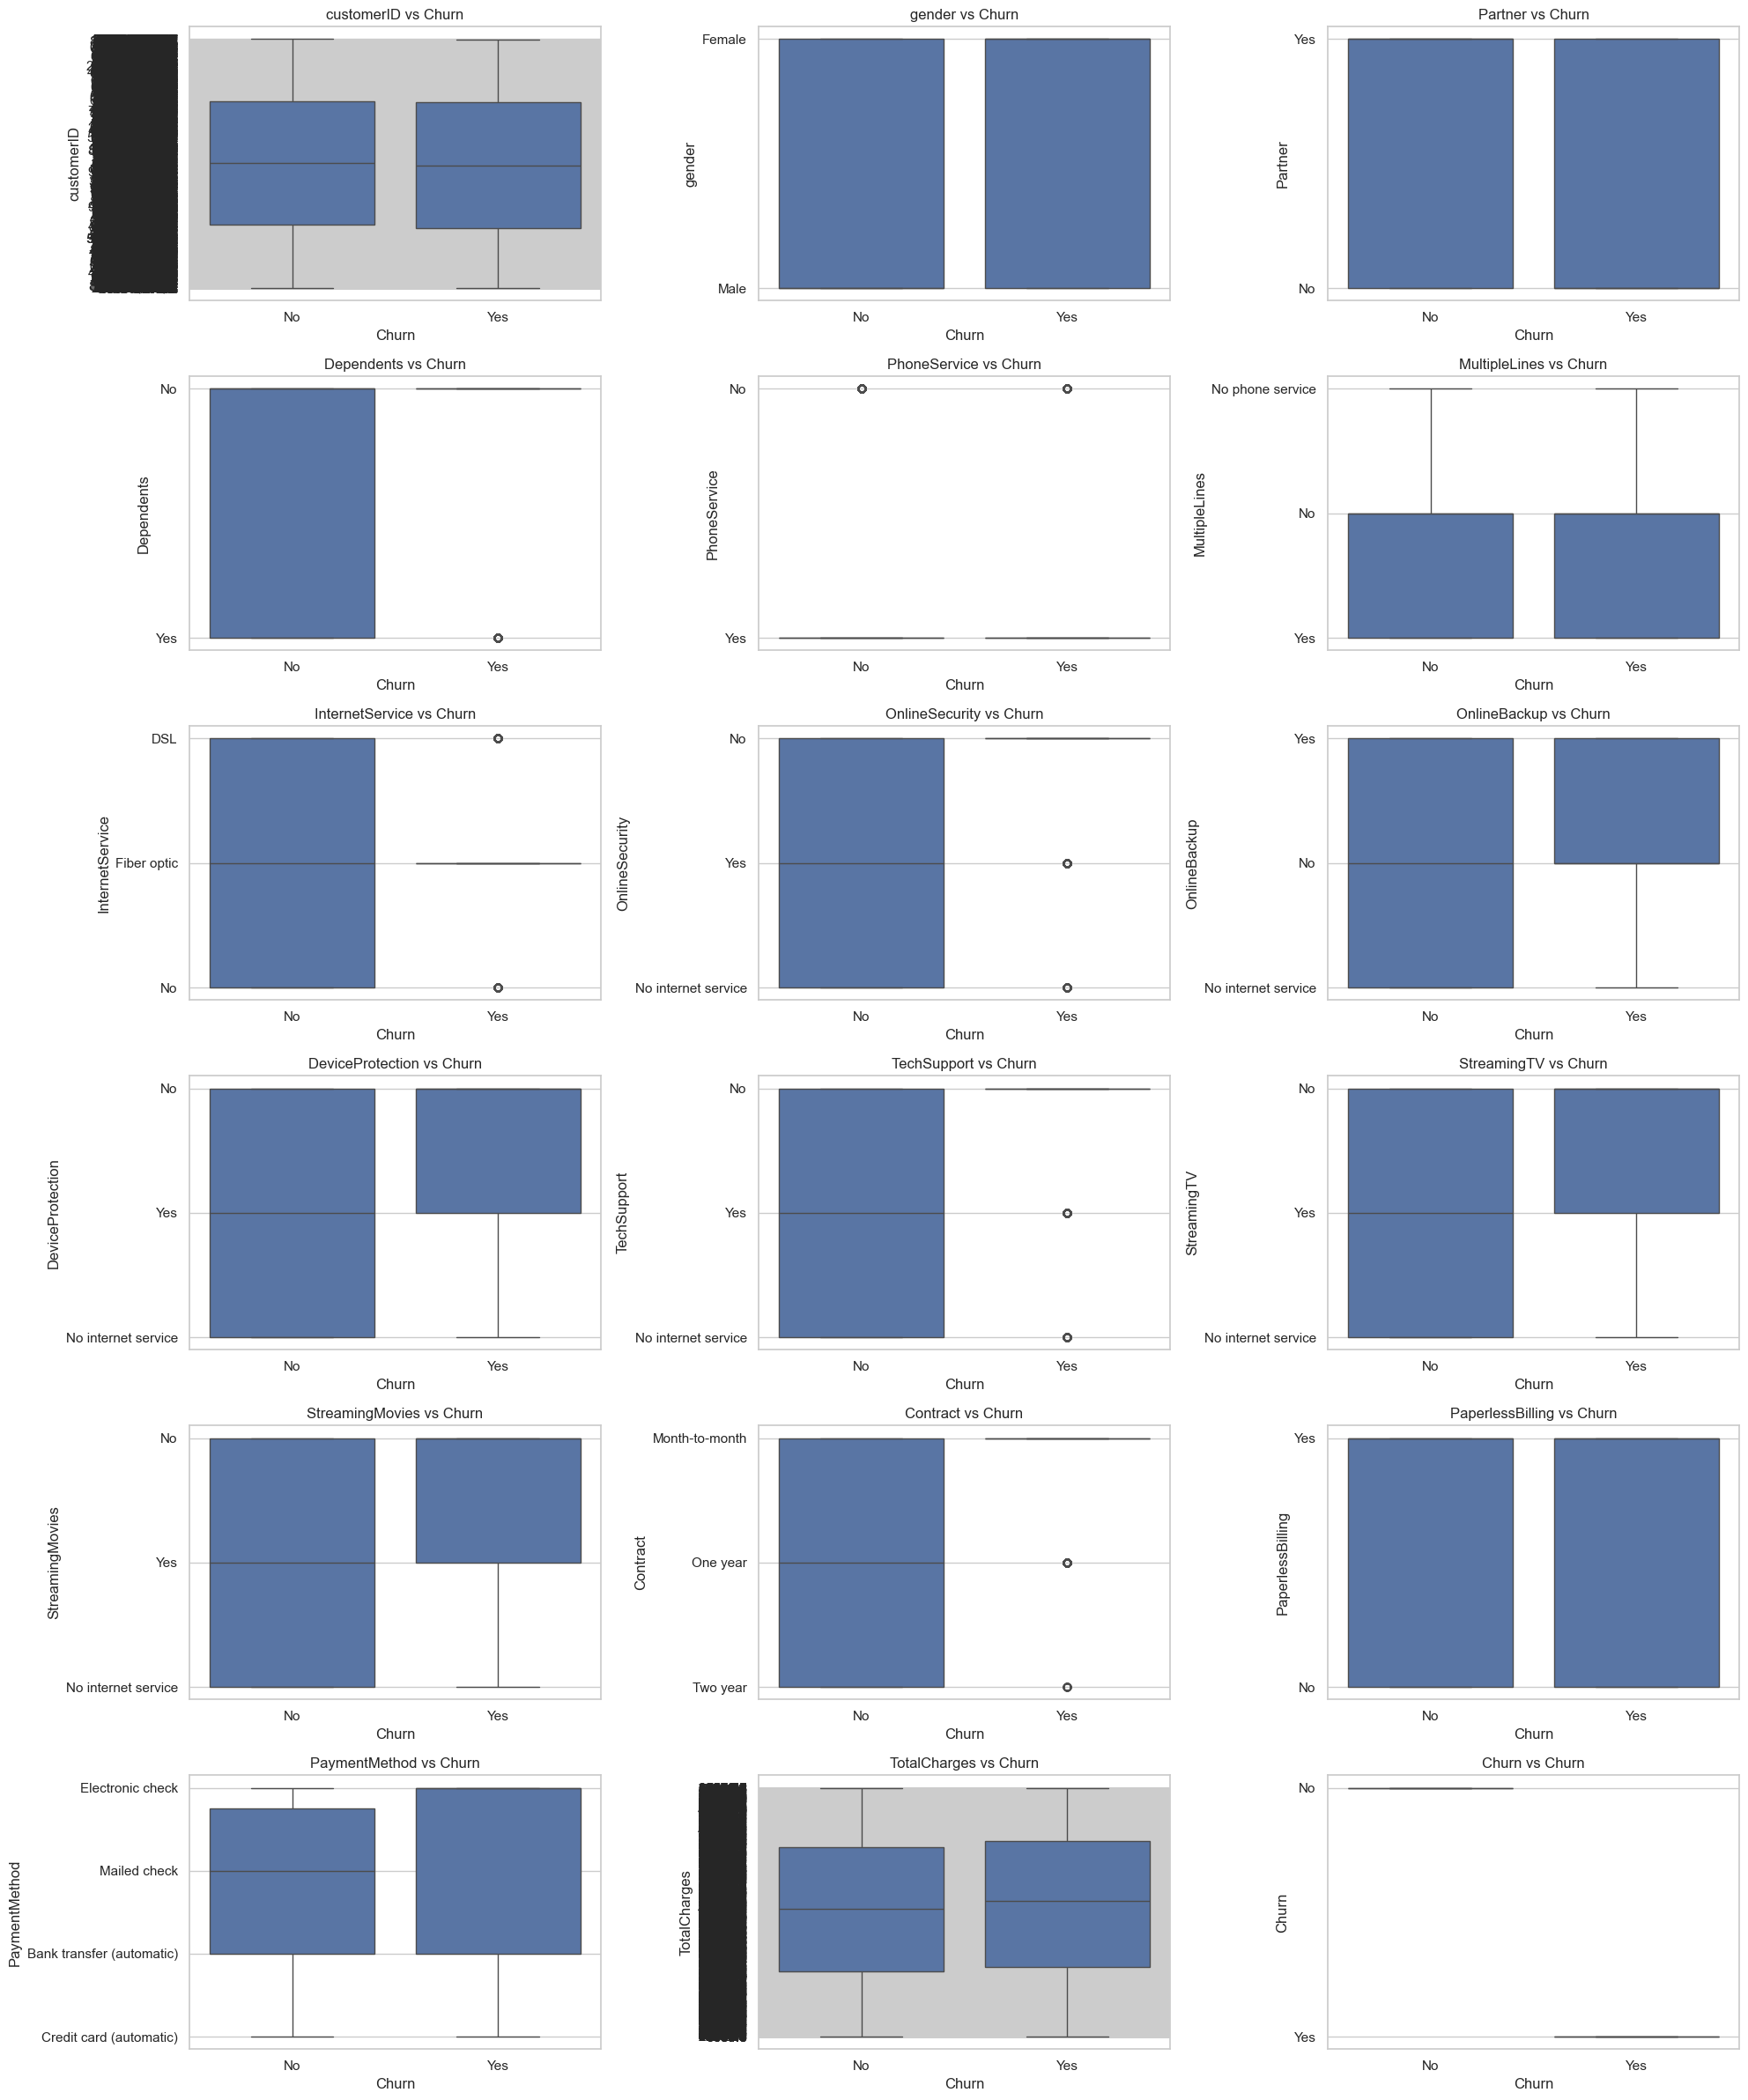

In [33]:
categorical_cols = df.select_dtypes(include=['object']).columns

n_cols = 3
n_rows = (len(categorical_cols) + n_cols -1) // n_cols

plt.figure(figsize=(20, n_rows * 4))

for i, col in enumerate(categorical_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.boxplot(data=df, x="Churn", y=col)
    plt.title(f"{col} vs Churn")
    plt.tight_layout()

plt.show()

**Feature List**

**customerID: object, 고유ID, 식별값**

**gender: object, 성별**

**SeniorCitizen: int64, 고령자 여부(1 for Yes, 0 for No)**

**Partner: object, 결혼여부(Yes, No)**

**Dependents: object, 부양가족유무(Yes, No)**

**tenure: int64, 고객의 회사이용기간(월)**

**PhoneService: object, 전화 서비스 사용여부(Yes, No)**

**MultipleLines: object, 전화서비스 중 여러 회선 사용여부(Yes, No, No phone service) - PhoneService에 종속**

**InternetService: object, 인터넷서비스 유형(DSL, Fiber optic, No)**

**OnlineSecurity: object, 인터넷서비스 중 온라인보안 사용여부(Yes, No, No internet service) - InternetService에 종속**

**OnlineBackup: object, 인터넷서비스 중 온라인백업 사용여부(Yes, No, No internet service) - InternetService에 종속**

**DeviceProtection: object, 인터넷서비스 중 기기보호 사용여부(Yes, No, No internet service) - InternetService에 종속**

**TechSupport: object, 인터넷서비스 중 기술지원 사용여부(Yes, No, No internet service) - InternetService에 종속**

**StreamingTV: object, 인터넷 서비스 중 스트리밍TV 사용여부(Yes, No, No internet service) - InternetService에 종속**

**StreamingMovies: object, 인터넷 서비스 중 스트리밍Movies 사용여부(Yes, No, No internet service) - InternetService에 종속**

**Contract: object, 계약유형(Month-to-month, One year, Two year)**

**PaperlessBilling: object, 고객의 무지불 청구서 사용여부(Yes, No)**

**PaymentMethod: object, 고객의 결제방법(Electronic check, Mailed check, Bank transfer, Credit card)**

**MonthlyCharges: object, 현재 요금제 기준 월 비용**

**TotalCharges: object, 고객의 총 청구 금액**
-  float 형태인데, object 타입으로 되어있으므로 변경 필요. 변경과정에서 결측치 확인 시 결측치 제거 필요(승룡님)

**numAdminTickets: object, 고객이 제출한 관리 요청 수**

**numTechTickets: object, 고객이 제출한 기술 요청 수**

**Churn: 이탈 여부(Yes, No)**

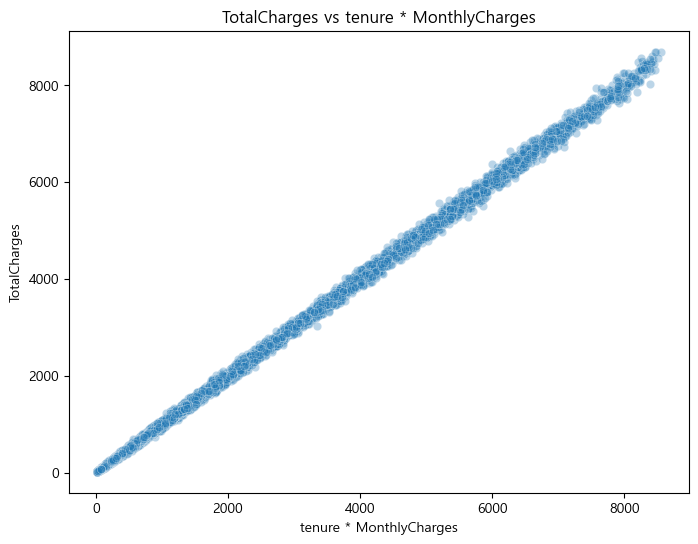

In [ ]:
# TotalCharges 결측 처리방법을 위한 TotalCharges 규명

import matplotlib.pyplot as plt
import seaborn as sns

df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
# 계산
df["tenure_x_monthly"] = df["tenure"] * df["MonthlyCharges"]

# 산점도 그리기
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=df["tenure_x_monthly"],
    y=df["TotalCharges"],
    alpha=0.3
)

plt.xlabel("tenure * MonthlyCharges")
plt.ylabel("TotalCharges")
plt.title("TotalCharges vs tenure * MonthlyCharges")
plt.show()

In [5]:
df[["tenure_x_monthly", "TotalCharges"]].corr()

,tenure_x_monthly,TotalCharges
tenure_x_monthly,1.00000,0.99956
TotalCharges,0.99956,1.00000


In [ ]:
# 둘의 상관관계가 1에 가깝기 때문에, tenure * Monthly_Charges = Total_Charges로 결측값을 채워보자 라는 가설
# Total_Charges가 결측인 값은 tenure가 0이였기 때문에, 0인걸로 생각. Monthly_charges는 값을 가지고